In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
path = ''

In [3]:
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Create count vectorizer with ngrams

In [6]:
vect = CountVectorizer(ngram_range=(1, 2), max_features=1000)
X_dtm_txt = vect.fit_transform(dataTraining['plot'])
X_dtm_txt.shape

(7895, 1000)

In [7]:
print(vect.get_feature_names()[:50])

['able', 'able to', 'about', 'about the', 'about to', 'accident', 'across', 'act', 'action', 'actually', 'affair', 'after', 'after the', 'again', 'against', 'against the', 'age', 'agent', 'ago', 'alex', 'alive', 'all', 'all of', 'all the', 'alone', 'along', 'along the', 'along with', 'already', 'also', 'although', 'always', 'america', 'american', 'among', 'an', 'an old', 'and', 'and has', 'and he', 'and her', 'and his', 'and is', 'and she', 'and that', 'and the', 'and their', 'and then', 'and they', 'and when']


# Create y

In [8]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

# Split train and test

In [9]:
X_train_txt1, X_test_txt1, y_train_genres_txt1, y_test_genres_txt1 = train_test_split(X_dtm_txt, y_genres, test_size=0.33, random_state=42)

# Train multi-class multi-label model

In [10]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [11]:
clf.fit(X_train_txt1, y_train_genres_txt1)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
          n_jobs=1)

In [12]:
y_pred_genres_txt1 = clf.predict_proba(X_test_txt1)

In [38]:
roc_auc_RF=roc_auc_score(y_test_genres_txt1, y_pred_genres_txt1, average='macro')

In [39]:
roc_auc_RF

0.7437754044790014

# Apply models to kaggle test

In [14]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF.csv', index_label='ID')

## Sequence Classification using LSTM

In [ ]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

In [15]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

C:\Users\jessi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
from livelossplot import PlotLossesKeras
%matplotlib inline

In [17]:
X = dataTraining['plot'].tolist()

Create vocabulary

In [18]:
# For vocabulary only the intersec characters is used to avoid issues with data collection
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [19]:
# Max len
max_url_len = 1500 
X = [x[:max_url_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [20]:
len(X)

7895

In [21]:
X_pad = sequence.pad_sequences(X, maxlen=max_url_len)

In [22]:
X_pad

array([[ 0,  0,  0, ..., 42, 32, 70],
       [ 0,  0,  0, ...,  8, 32, 70],
       [ 0,  0,  0, ..., 45, 32, 70],
       ...,
       [ 0,  0,  0, ..., 27, 32, 70],
       [42, 64, 67, ..., 23, 38, 57],
       [ 0,  0,  0, ..., 57, 32, 70]])

In [23]:
X_pad.shape

(7895, 1500)

In [27]:
X_trainlstm, X_testlstm, y_trainlstm, y_testlstm = train_test_split(X_pad, y_genres, test_size=0.20, random_state=42)

In [29]:
X_trainlstm.shape,X_testlstm.shape, y_trainlstm.shape, y_testlstm.shape

((6316, 1500), (1579, 1500), (6316, 24), (1579, 24))

In [30]:
modellstm = Sequential()
modellstm.add(Embedding(len(vocabulary) + 1, 128, input_length=max_url_len))
modellstm.add(LSTM(32))
modellstm.add(Dropout(0.5))
modellstm.add(Dense(24, activation='sigmoid'))
modellstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

modellstm.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 128)         9600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
Total params: 31,000
Trainable params: 31,000
Non-trainable params: 0
_________________________________________________________________


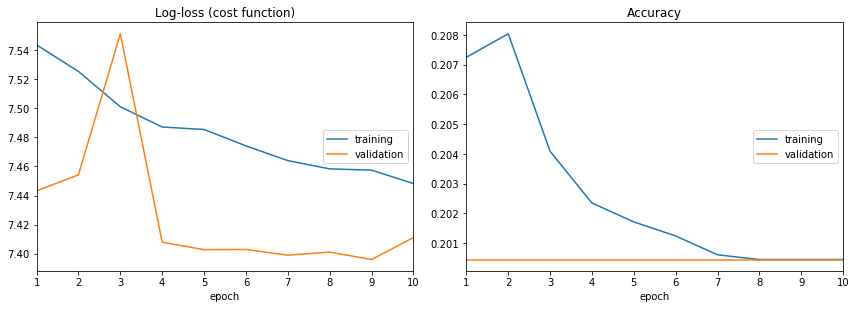

In [34]:
modellstm.fit(X_trainlstm, y_trainlstm, validation_data=[X_trainlstm, y_trainlstm], 
          batch_size=128, epochs=10, verbose=1,
          callbacks=[PlotLossesKeras()])

In [35]:
#ROC
y_predlstm = modellstm.predict_proba(X_testlstm)

In [36]:
roc_auc_lstm=roc_auc_score(y_testlstm, y_predlstm, average='macro')

In [37]:
roc_auc_lstm

0.5488997973935582

#### LSTM is a recursive neural network, which uses information in the short or long term to improve the output outcome. For the case study it is not the best model to predict the genre of the film. 
#### This type of network is widely used for recognition of handwriting, speech recognition, gesture recognition, etc.

## Sequence Classification using CNN

In [66]:
XN=dataTraining['plot']
vect = CountVectorizer(ngram_range=(1, 4), max_features=2000)
X_dtmCNN = vect.fit_transform(XN)
X_dtmCNN.shape

(7895, 2000)

In [67]:
X_trainCNN, X_testCNN, y_trainCNN, y_testCNN = train_test_split(X_dtmCNN, y_genres, test_size=0.20, random_state=42)

In [68]:
X_trainCNN.shape, X_testCNN.shape, y_trainCNN.shape, y_testCNN.shape

((6316, 2000), (1579, 2000), (6316, 24), (1579, 24))

In [110]:
from keras.layers import Dense, Dropout, Activation, BatchNormalization

modelCNN = Sequential()
modelCNN.add(Dense(512, input_shape=X_dtmCNN.shape[1:], activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(Dropout(0.8))
modelCNN.add(Dense(128, activation='relu'))
modelCNN.add(Dense(64, activation='relu'))
modelCNN.add(Dense(24, activation='sigmoid'))
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               1024512   
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 24)                1560      
Total params: 1,102,040
Trainable params: 1,101,016
Non-trainable params: 1,024
______________________________________________________________

In [111]:
#Compilación
modelCNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

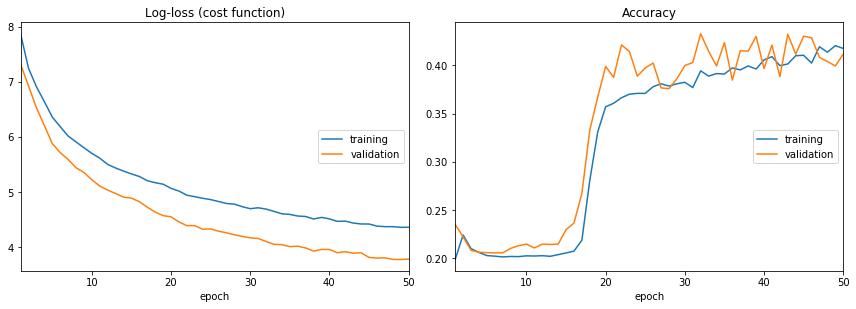

In [112]:
#Fit
modelCNN.fit(X_trainCNN, y_trainCNN, validation_data=[X_trainCNN, y_trainCNN], 
          batch_size=128, epochs=50, verbose=2,
          callbacks=[PlotLossesKeras()])

In [113]:
#ROC
y_predCNN = modelCNN.predict_proba(X_testCNN)

In [114]:
roc_auc_CNN=roc_auc_score(y_testCNN, y_predCNN, average='macro')

In [115]:
roc_auc_CNN

0.8530168339543108

## SUMMARY

In [116]:
roc_auc_RF,roc_auc_lstm,roc_auc_CNN

(0.7437754044790014, 0.5488997973935582, 0.8530168339543108)

Comparing the result of the Random Forest, LSTM and CNN models; we select the CNN network since it has the value of the highest ROC curve value, making the CNN model better predict the gender classification for each film.

The convultional network model has the great advantage of being able to train each leg of the network to perform a task, which significantly reduces the number of hidden layers, for the case study we activate 4 layers. After each convolution layer there is a reduction and we generate the final output layer to predict the genre of classification of a film within the 24 existing genres.

For the activation of layers we use "Relu", a simple and fast activator to calculate. We also use a dropout of 0.80 that randomly deactivates neurons during training, to regularize the model and thus prevents the units of the network from adapting to each other. This value of 0.8 for the Dropout was the best performance we found when varying the heat between 0.3 and 0.9.

We incorporate in the network, BatchNormalization, so that in each transformation it maintains the average activation close to 0 and the standard deviation of activation close to 1; reduce the error.


In [117]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = modelCNN.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_CNN.csv', index_label='ID')